# 多层感知机
:label:`sec_mlp`

在 :numref:`chap_linear`中，
我们介绍了softmax回归（ :numref:`sec_softmax`），
然后我们从零开始实现了softmax回归（ :numref:`sec_softmax_scratch`），
接着使用高级API实现了算法（ :numref:`sec_softmax_concise`），
并训练分类器从低分辨率图像中识别10类服装。
在这个过程中，我们学习了如何处理数据，如何将输出转换为有效的概率分布，
并应用适当的损失函数，根据模型参数最小化损失。
我们已经在简单的线性模型背景下掌握了这些知识，
现在我们可以开始对深度神经网络的探索，这也是本书主要涉及的一类模型。

## 隐藏层

我们在 :numref:`subsec_linear_model`中描述了仿射变换，
它是一种带有偏置项的线性变换。
首先，回想一下如 :numref:`fig_softmaxreg`中所示的softmax回归的模型架构。
该模型通过单个仿射变换将我们的输入直接映射到输出，然后进行softmax操作。
如果我们的标签通过仿射变换后确实与我们的输入数据相关，那么这种方法确实足够了。
但是，仿射变换中的*线性*是一个很强的假设。

### 线性模型可能会出错

例如，线性意味着*单调*假设：
任何特征的增大都会导致模型输出的增大（如果对应的权重为正），
或者导致模型输出的减小（如果对应的权重为负）。
有时这是有道理的。
例如，如果我们试图预测一个人是否会偿还贷款。
我们可以认为，在其他条件不变的情况下，
收入较高的申请人比收入较低的申请人更有可能偿还贷款。
但是，虽然收入与还款概率存在单调性，但它们不是线性相关的。
收入从0增加到5万，可能比从100万增加到105万带来更大的还款可能性。
处理这一问题的一种方法是对我们的数据进行预处理，
使线性变得更合理，如使用收入的对数作为我们的特征。

然而我们可以很容易找出违反单调性的例子。
例如，我们想要根据体温预测死亡率。
对体温高于37摄氏度的人来说，温度越高风险越大。
然而，对体温低于37摄氏度的人来说，温度越高风险就越低。
在这种情况下，我们也可以通过一些巧妙的预处理来解决问题。
例如，我们可以使用与37摄氏度的距离作为特征。

但是，如何对猫和狗的图像进行分类呢？
增加位置$(13, 17)$处像素的强度是否总是增加（或降低）图像描绘狗的似然？
对线性模型的依赖对应于一个隐含的假设，
即区分猫和狗的唯一要求是评估单个像素的强度。
在一个倒置图像后依然保留类别的世界里，这种方法注定会失败。

与我们前面的例子相比，这里的线性很荒谬，
而且我们难以通过简单的预处理来解决这个问题。
这是因为任何像素的重要性都以复杂的方式取决于该像素的上下文（周围像素的值）。
我们的数据可能会有一种表示，这种表示会考虑到我们在特征之间的相关交互作用。
在此表示的基础上建立一个线性模型可能会是合适的，
但我们不知道如何手动计算这么一种表示。
对于深度神经网络，我们使用观测数据来联合学习隐藏层表示和应用于该表示的线性预测器。

### 在网络中加入隐藏层

我们可以通过在网络中加入一个或多个隐藏层来克服线性模型的限制，
使其能处理更普遍的函数关系类型。
要做到这一点，最简单的方法是将许多全连接层堆叠在一起。
每一层都输出到上面的层，直到生成最后的输出。
我们可以把前$L-1$层看作表示，把最后一层看作线性预测器。
这种架构通常称为*多层感知机*（multilayer perceptron），通常缩写为*MLP*。
下面，我们以图的方式描述了多层感知机（ :numref:`fig_mlp`）。

![一个单隐藏层的多层感知机，具有5个隐藏单元](../img/mlp.svg)
:label:`fig_mlp`

这个多层感知机有4个输入，3个输出，其隐藏层包含5个隐藏单元。
输入层不涉及任何计算，因此使用此网络产生输出只需要实现隐藏层和输出层的计算。
因此，这个多层感知机中的层数为2。
注意，这两个层都是全连接的。
每个输入都会影响隐藏层中的每个神经元，
而隐藏层中的每个神经元又会影响输出层中的每个神经元。

然而，正如 :numref:`subsec_parameterization-cost-fc-layers`所说，
具有全连接层的多层感知机的参数开销可能会高得令人望而却步。
即使在不改变输入或输出大小的情况下，
可能在参数节约和模型有效性之间进行权衡 :cite:`Zhang.Tay.Zhang.ea.2021`。

### 从线性到非线性

同之前的章节一样，
我们通过矩阵$\mathbf{X} \in \mathbb{R}^{n \times d}$
来表示$n$个样本的小批量，
其中每个样本具有$d$个输入特征。
对于具有$h$个隐藏单元的单隐藏层多层感知机，
用$\mathbf{H} \in \mathbb{R}^{n \times h}$表示隐藏层的输出，
称为*隐藏表示*（hidden representations）。
在数学或代码中，$\mathbf{H}$也被称为*隐藏层变量*（hidden-layer variable）
或*隐藏变量*（hidden variable）。
因为隐藏层和输出层都是全连接的，
所以我们有隐藏层权重$\mathbf{W}^{(1)} \in \mathbb{R}^{d \times h}$
和隐藏层偏置$\mathbf{b}^{(1)} \in \mathbb{R}^{1 \times h}$
以及输出层权重$\mathbf{W}^{(2)} \in \mathbb{R}^{h \times q}$
和输出层偏置$\mathbf{b}^{(2)} \in \mathbb{R}^{1 \times q}$。
形式上，我们按如下方式计算单隐藏层多层感知机的输出
$\mathbf{O} \in \mathbb{R}^{n \times q}$：

$$
\begin{aligned}
    \mathbf{H} & = \mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}, \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.
\end{aligned}
$$

注意在添加隐藏层之后，模型现在需要跟踪和更新额外的参数。
可我们能从中得到什么好处呢？在上面定义的模型里，我们没有好处！
原因很简单：上面的隐藏单元由输入的仿射函数给出，
而输出（softmax操作前）只是隐藏单元的仿射函数。
仿射函数的仿射函数本身就是仿射函数，
但是我们之前的线性模型已经能够表示任何仿射函数。

我们可以证明这一等价性，即对于任意权重值，
我们只需合并隐藏层，便可产生具有参数
$\mathbf{W} = \mathbf{W}^{(1)}\mathbf{W}^{(2)}$
和$\mathbf{b} = \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)}$
的等价单层模型：

$$
\mathbf{O} = (\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})\mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W} + \mathbf{b}.
$$

为了发挥多层架构的潜力，
我们还需要一个额外的关键要素：
在仿射变换之后对每个隐藏单元应用非线性的*激活函数*（activation function）$\sigma$。
激活函数的输出（例如，$\sigma(\cdot)$）被称为*活性值*（activations）。
一般来说，有了激活函数，就不可能再将我们的多层感知机退化成线性模型：

$$
\begin{aligned}
    \mathbf{H} & = \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}), \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.\\
\end{aligned}
$$

由于$\mathbf{X}$中的每一行对应于小批量中的一个样本，
出于记号习惯的考量，
我们定义非线性函数$\sigma$也以按行的方式作用于其输入，
即一次计算一个样本。
我们在 :numref:`subsec_softmax_vectorization`中
以相同的方式使用了softmax符号来表示按行操作。
但是本节应用于隐藏层的激活函数通常不仅按行操作，也按元素操作。
这意味着在计算每一层的线性部分之后，我们可以计算每个活性值，
而不需要查看其他隐藏单元所取的值。对于大多数激活函数都是这样。

为了构建更通用的多层感知机，
我们可以继续堆叠这样的隐藏层，
例如$\mathbf{H}^{(1)} = \sigma_1(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})$和$\mathbf{H}^{(2)} = \sigma_2(\mathbf{H}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)})$，
一层叠一层，从而产生更有表达能力的模型。

### 通用近似定理

多层感知机可以通过隐藏神经元，捕捉到输入之间复杂的相互作用，
这些神经元依赖于每个输入的值。
我们可以很容易地设计隐藏节点来执行任意计算。
例如，在一对输入上进行基本逻辑操作，多层感知机是通用近似器。
即使是网络只有一个隐藏层，给定足够的神经元和正确的权重，
我们可以对任意函数建模，尽管实际中学习该函数是很困难的。
神经网络有点像C语言。
C语言和任何其他现代编程语言一样，能够表达任何可计算的程序。
但实际上，想出一个符合规范的程序才是最困难的部分。

而且，虽然一个单隐层网络能学习任何函数，
但并不意味着我们应该尝试使用单隐藏层网络来解决所有问题。
事实上，通过使用更深（而不是更广）的网络，我们可以更容易地逼近许多函数。
我们将在后面的章节中进行更细致的讨论。

## 激活函数
:label:`subsec_activation_functions`

*激活函数*（activation function）通过计算加权和并加上偏置来确定神经元是否应该被激活，
它们将输入信号转换为输出的可微运算。
大多数激活函数都是非线性的。
由于激活函数是深度学习的基础，下面(**简要介绍一些常见的激活函数**)。


In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

### ReLU函数

最受欢迎的激活函数是*修正线性单元*（Rectified linear unit，*ReLU*），
因为它实现简单，同时在各种预测任务中表现良好。
[**ReLU提供了一种非常简单的非线性变换**]。
给定元素$x$，ReLU函数被定义为该元素与$0$的最大值：

(**$$\operatorname{ReLU}(x) = \max(x, 0).$$**)

通俗地说，ReLU函数通过将相应的活性值设为0，仅保留正元素并丢弃所有负元素。
为了直观感受一下，我们可以画出函数的曲线图。
正如从图中所看到，激活函数是分段线性的。


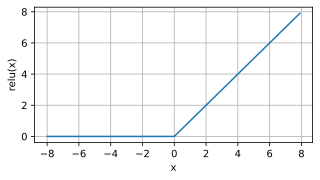

In [2]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

当输入为负时，ReLU函数的导数为0，而当输入为正时，ReLU函数的导数为1。
注意，当输入值精确等于0时，ReLU函数不可导。
在此时，我们默认使用左侧的导数，即当输入为0时导数为0。
我们可以忽略这种情况，因为输入可能永远都不会是0。
这里引用一句古老的谚语，“如果微妙的边界条件很重要，我们很可能是在研究数学而非工程”，
这个观点正好适用于这里。
下面我们绘制ReLU函数的导数。


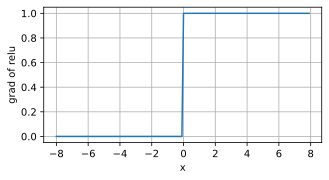

In [3]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

使用ReLU的原因是，它求导表现得特别好：要么让参数消失，要么让参数通过。
这使得优化表现得更好，并且ReLU减轻了困扰以往神经网络的梯度消失问题（稍后将详细介绍）。

注意，ReLU函数有许多变体，包括*参数化ReLU*（Parameterized ReLU，*pReLU*）
函数 :cite:`He.Zhang.Ren.ea.2015`。
该变体为ReLU添加了一个线性项，因此即使参数是负的，某些信息仍然可以通过：

$$\operatorname{pReLU}(x) = \max(0, x) + \alpha \min(0, x).$$

### sigmoid函数

[**对于一个定义域在$\mathbb{R}$中的输入，
*sigmoid函数*将输入变换为区间(0, 1)上的输出**]。
因此，sigmoid通常称为*挤压函数*（squashing function）：
它将范围（-inf, inf）中的任意输入压缩到区间（0, 1）中的某个值：

(**$$\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$**)

在最早的神经网络中，科学家们感兴趣的是对“激发”或“不激发”的生物神经元进行建模。
因此，这一领域的先驱可以一直追溯到人工神经元的发明者麦卡洛克和皮茨，他们专注于阈值单元。
阈值单元在其输入低于某个阈值时取值0，当输入超过阈值时取值1。

当人们逐渐关注到到基于梯度的学习时，
sigmoid函数是一个自然的选择，因为它是一个平滑的、可微的阈值单元近似。
当我们想要将输出视作二元分类问题的概率时，
sigmoid仍然被广泛用作输出单元上的激活函数
（sigmoid可以视为softmax的特例）。
然而，sigmoid在隐藏层中已经较少使用，
它在大部分时候被更简单、更容易训练的ReLU所取代。
在后面关于循环神经网络的章节中，我们将描述利用sigmoid单元来控制时序信息流的架构。

下面，我们绘制sigmoid函数。
注意，当输入接近0时，sigmoid函数接近线性变换。


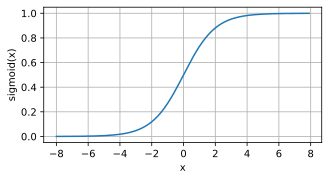

In [4]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

sigmoid函数的导数为下面的公式：

$$\frac{d}{dx} \operatorname{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \operatorname{sigmoid}(x)\left(1-\operatorname{sigmoid}(x)\right).$$

sigmoid函数的导数图像如下所示。
注意，当输入为0时，sigmoid函数的导数达到最大值0.25；
而输入在任一方向上越远离0点时，导数越接近0。


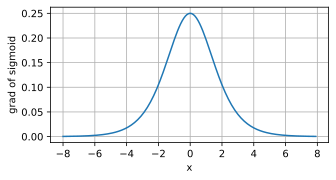

In [5]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

### tanh函数

与sigmoid函数类似，
[**tanh(双曲正切)函数也能将其输入压缩转换到区间(-1, 1)上**]。
tanh函数的公式如下：

(**$$\operatorname{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$**)

下面我们绘制tanh函数。
注意，当输入在0附近时，tanh函数接近线性变换。
函数的形状类似于sigmoid函数，
不同的是tanh函数关于坐标系原点中心对称。


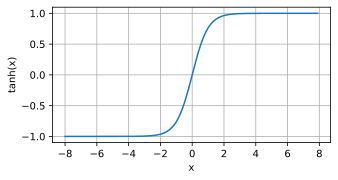

In [6]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

tanh函数的导数是：

$$\frac{d}{dx} \operatorname{tanh}(x) = 1 - \operatorname{tanh}^2(x).$$

tanh函数的导数图像如下所示。
当输入接近0时，tanh函数的导数接近最大值1。
与我们在sigmoid函数图像中看到的类似，
输入在任一方向上越远离0点，导数越接近0。


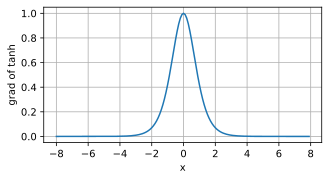

In [7]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

总结一下，我们现在了解了如何结合非线性函数来构建具有更强表达能力的多层神经网络架构。
顺便说一句，这些知识已经让你掌握了一个类似于1990年左右深度学习从业者的工具。
在某些方面，你比在20世纪90年代工作的任何人都有优势，
因为你可以利用功能强大的开源深度学习框架，只需几行代码就可以快速构建模型，
而以前训练这些网络需要研究人员编写数千行的C或Fortran代码。

## 小结

* 多层感知机在输出层和输入层之间增加一个或多个全连接隐藏层，并通过激活函数转换隐藏层的输出。
* 常用的激活函数包括ReLU函数、sigmoid函数和tanh函数。

## 练习

1. 计算pReLU激活函数的导数。
2. 证明一个仅使用ReLU（或pReLU）的多层感知机构造了一个连续的分段线性函数。
3. 证明$\operatorname{tanh}(x) + 1 = 2 \operatorname{sigmoid}(2x)$。
4. 假设我们有一个非线性单元，将它一次应用于一个小批量的数据。这会导致什么样的问题？


1. 计算pReLU激活函数的导数。

我来详细推导pReLU激活函数的导数。

## pReLU激活函数定义

pReLU函数定义为：
$$\operatorname{pReLU}(x) = \max(0, x) + \alpha \min(0, x)$$

其中 $\alpha$ 是一个可学习的参数。

## 分段表示

我们可以将pReLU函数写成分段形式：
$$\operatorname{pReLU}(x) = \begin{cases} 
x & \text{if } x > 0 \\
\alpha x & \text{if } x < 0 \\
0 & \text{if } x = 0
\end{cases}$$

## 导数推导

对pReLU函数求导：

当 $x > 0$ 时：
$$\frac{d}{dx}\operatorname{pReLU}(x) = \frac{d}{dx}x = 1$$

当 $x < 0$ 时：
$$\frac{d}{dx}\operatorname{pReLU}(x) = \frac{d}{dx}(\alpha x) = \alpha$$

当 $x = 0$ 时：
在 $x = 0$ 点，函数不可导，因为左导数和右导数不相等：
- 右导数：$\lim_{h \to 0^+} \frac{\operatorname{pReLU}(h) - \operatorname{pReLU}(0)}{h} = \lim_{h \to 0^+} \frac{h - 0}{h} = 1$
- 左导数：$\lim_{h \to 0^-} \frac{\operatorname{pReLU}(h) - \operatorname{pReLU}(0)}{h} = \lim_{h \to 0^-} \frac{\alpha h - 0}{h} = \alpha$

通常在实际应用中，当 $x = 0$ 时，可以选择使用左导数 $\alpha$ 或右导数 $1$，或者将导数设为两者的平均值 $\frac{1 + \alpha}{2}$。

## 最终结果

因此，pReLU函数的导数为：
$$\frac{d}{dx}\operatorname{pReLU}(x) = \begin{cases} 
1 & \text{if } x > 0 \\
\alpha & \text{if } x < 0 \\
\text{undefined} \text{ 或 } \alpha \text{ 或 } 1 & \text{if } x = 0
\end{cases}$$

也可以使用符号函数表示为：
$$\frac{d}{dx}\operatorname{pReLU}(x) = \begin{cases} 
1 & \text{if } x > 0 \\
\alpha & \text{if } x < 0 \\
\text{undefined} & \text{if } x = 0
\end{cases}$$

在实际实现中，通常会避免在 $x = 0$ 时处理导数的不连续性，或者简单地将其设为 $\alpha$ 或 $1$。

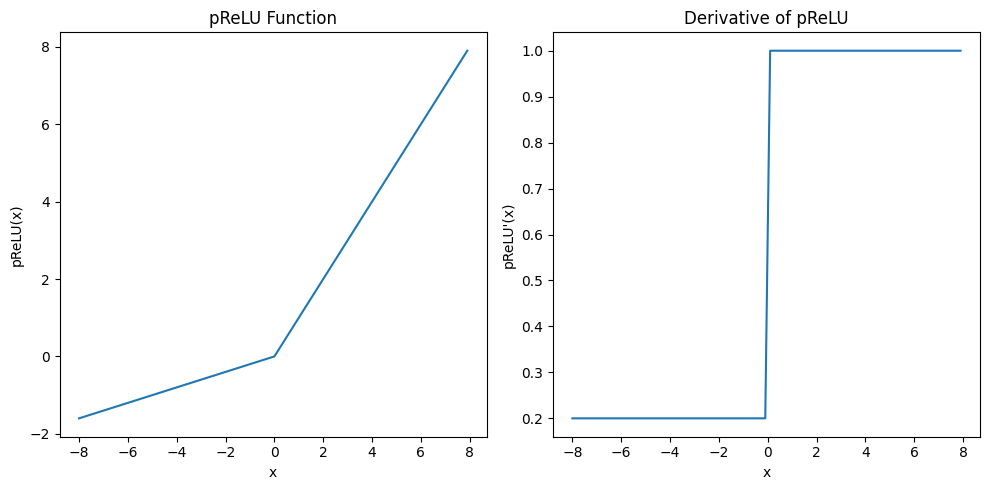

pReLU函数导数分析:
- 当 x > 0 时: pReLU'(x) = 1
- 当 x < 0 时: pReLU'(x) = α = 0.2
- 当 x = 0 时: 导数未定义，通常取左导数α或右导数1


In [1]:
import torch
import matplotlib.pyplot as plt

# 定义pReLU函数
def prelu(x, alpha):
    return torch.max(torch.tensor(0.0), x) + alpha * torch.min(torch.tensor(0.0), x)

# 创建输入张量
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)

# 设置alpha参数
alpha = 0.2

# 计算pReLU输出
y = prelu(x, alpha)

# 绘制pReLU函数
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x.detach().numpy(), y.detach().numpy())
plt.title('pReLU Function')
plt.xlabel('x')
plt.ylabel('pReLU(x)')

# 计算导数
y.backward(torch.ones_like(x), retain_graph=True)

# 绘制导数
plt.subplot(1, 2, 2)
plt.plot(x.detach().numpy(), x.grad.numpy())
plt.title('Derivative of pReLU')
plt.xlabel('x')
plt.ylabel("pReLU'(x)")
plt.tight_layout()
plt.show()

# 清除梯度
x.grad.zero_()

# 解析形式的导数计算
def prelu_derivative(x, alpha):
    """
    pReLU导数的解析形式:
    - 当 x > 0 时, 导数为 1
    - 当 x < 0 时, 导数为 α
    - 当 x = 0 时, 导数未定义(通常取左导数或右导数)
    """
    derivative = torch.where(x > 0, torch.tensor(1.0), torch.tensor(alpha))
    return derivative

print("pReLU函数导数分析:")
print("- 当 x > 0 时: pReLU'(x) = 1")
print(f"- 当 x < 0 时: pReLU'(x) = α = {alpha}")
print("- 当 x = 0 时: 导数未定义，通常取左导数α或右导数1")

2. 证明一个仅使用ReLU（或pReLU）的多层感知机构造了一个连续的分段线性函数。

我来证明一个仅使用ReLU（或pReLU）的多层感知机构造了一个连续的分段线性函数。

## 证明过程

### 1. 单层情况

首先考虑单层神经网络，其输出为：
$$\mathbf{o} = \sigma(\mathbf{W}^{(1)}\mathbf{x} + \mathbf{b}^{(1)})$$

其中 $\sigma$ 是ReLU或pReLU激活函数。

对于ReLU函数：
$$\operatorname{ReLU}(x) = \max(0, x) = \begin{cases} 
x & \text{if } x \geq 0 \\
0 & \text{if } x < 0
\end{cases}$$

对于pReLU函数：
$$\operatorname{pReLU}(x) = \max(0, x) + \alpha \min(0, x) = \begin{cases} 
x & \text{if } x \geq 0 \\
\alpha x & \text{if } x < 0
\end{cases}$$

在这两种情况下，激活函数都是分段线性函数：
- ReLU在$x=0$处分段，每段都是线性函数（斜率为0或1）
- pReLU在$x=0$处分段，每段都是线性函数（斜率为$\alpha$或1）

因此，单层网络的输出是分段线性函数。

### 2. 多层情况（归纳法）

假设具有$L-1$层的网络输出是分段线性函数，现在考虑$L$层网络。

第$L$层的输出为：
$$\mathbf{o}^{(L)} = \sigma^{(L)}(\mathbf{W}^{(L)}\mathbf{o}^{(L-1)} + \mathbf{b}^{(L)})$$

根据归纳假设，$\mathbf{o}^{(L-1)}$是分段线性函数。由于矩阵乘法$\mathbf{W}^{(L)}\mathbf{o}^{(L-1)}$和加法$\mathbf{W}^{(L)}\mathbf{o}^{(L-1)} + \mathbf{b}^{(L)}$都是线性运算，因此结果仍然是分段线性函数。

再应用分段线性激活函数$\sigma^{(L)}$（ReLU或pReLU），结果仍然是分段线性函数，因为：
- 分段线性函数的线性组合仍是分段线性函数
- 分段线性函数的分段线性变换仍是分段线性函数

### 3. 连续性

ReLU和pReLU函数都是连续函数：
- ReLU在$x=0$处连续，因为$\lim_{x \to 0^-} \operatorname{ReLU}(x) = 0 = \lim_{x \to 0^+} \operatorname{ReLU}(x) = \operatorname{ReLU}(0)$
- pReLU在$x=0$处连续，因为$\lim_{x \to 0^-} \operatorname{pReLU}(x) = 0 = \lim_{x \to 0^+} \operatorname{pReLU}(x) = \operatorname{pReLU}(0)$

线性变换保持连续性，因此整个网络构造的是连续函数。

## 结论

通过数学归纳法，我们证明了：
1. 单层网络构造分段线性函数
2. 如果前$L-1$层构造分段线性函数，则第$L$层也构造分段线性函数
3. 整个多层感知机构造的是连续的分段线性函数

这个性质解释了为什么多层感知机虽然只使用简单的激活函数，却能逼近复杂的非线性函数。每个神经元根据其输入是否超过阈值来"开启"或"关闭"，在不同区域形成不同的线性行为，整体上形成复杂的分段线性近似。

3.证明$\operatorname{tanh}(x) + 1 = 2 \operatorname{sigmoid}(2x)$。

## 证明过程

首先，让我们回顾两个函数的定义：

- 双曲正切函数：$\operatorname{tanh}(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$
- sigmoid函数：$\operatorname{sigmoid}(x) = \frac{1}{1 + e^{-x}}$

现在我们来证明等式左边等于右边。

### 左边：$\operatorname{tanh}(x) + 1$

$$\operatorname{tanh}(x) + 1 = \frac{e^x - e^{-x}}{e^x + e^{-x}} + 1$$

通分：
$$= \frac{e^x - e^{-x} + e^x + e^{-x}}{e^x + e^{-x}}$$

$$= \frac{2e^x}{e^x + e^{-x}}$$

### 右边：$2 \operatorname{sigmoid}(2x)$

$$2 \operatorname{sigmoid}(2x) = 2 \cdot \frac{1}{1 + e^{-2x}}$$

$$= \frac{2}{1 + e^{-2x}}$$

为了便于比较，我们将分母乘以 $e^{2x}$：

$$= \frac{2}{1 + e^{-2x}} \cdot \frac{e^{2x}}{e^{2x}}$$

$$= \frac{2e^{2x}}{e^{2x} + 1}$$

$$= \frac{2e^{2x}}{e^{2x} + 1}$$

### 证明两式相等

现在我们比较左边和右边：

左边：$\frac{2e^x}{e^x + e^{-x}}$

右边：$\frac{2e^{2x}}{e^{2x} + 1}$

对右边进行变形，分子分母同时除以 $e^x$：

$$\frac{2e^{2x}}{e^{2x} + 1} = \frac{2e^{2x} \div e^x}{(e^{2x} + 1) \div e^x} = \frac{2e^x}{e^x + e^{-x}}$$

这正好等于左边的表达式。

## 结论

因此，我们证明了：
$$\operatorname{tanh}(x) + 1 = 2 \operatorname{sigmoid}(2x)$$

这个等式揭示了双曲正切函数和sigmoid函数之间的关系，这也是为什么在实际应用中，这两个函数经常可以互换使用的原因之一。

[Discussions](https://discuss.d2l.ai/t/1796)
